In [1]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
unfiltered = pd.read_csv('../data/dataset.csv')
unfiltered = unfiltered.drop(columns=['id'])
unfiltered['Salenumber_missing'] = unfiltered['sale_nbr'].isnull().astype(int)
unfiltered['sale_nbr'] = unfiltered['sale_nbr'].fillna(-1)
unfiltered

,sale_date,sale_price,sale_nbr,sale_warning,join_status,join_year,latitude,longitude,area,city,...,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_lakesamm,view_otherwater,view_other,submarket,Salenumber_missing
0,2014-11-15,236000,2.0,,nochg,2025,47.2917,-122.3658,53,FEDERAL WAY,...,0,0,0,0,0,0,0,0,I,0
1,1999-01-15,313300,-1.0,26,nochg,2025,47.6531,-122.1996,74,KIRKLAND,...,0,0,0,0,1,0,0,0,Q,1
2,2006-08-15,341000,1.0,,nochg,2025,47.4733,-122.1901,30,RENTON,...,0,0,0,0,0,0,0,0,K,0
3,1999-12-15,267000,1.0,,nochg,2025,47.4739,-122.3295,96,BURIEN,...,0,0,0,0,0,0,0,0,G,0
4,2018-07-15,1650000,2.0,,miss99,2025,47.7516,-122.1222,36,KING COUNTY,...,0,0,0,0,0,0,0,0,P,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2000-08-15,277500,1.0,,nochg,2025,47.5503,-122.0285,69,ISSAQUAH,...,0,0,0,0,0,0,0,0,O,0
199996,2019-07-15,1296000,2.0,,new,2025,47.6789,-122.1164,72,REDMOND,...,0,0,0,0,0,0,0,0,P,0
199997,2018-06-15,845000,2.0,,new,2025,47.6939,-122.3542,6,SEATTLE,...,0,0,0,0,0,0,0,0,B,0
199998,2018-06-15,890000,2.0,,nochg,2025,47.6433,-122.0613,35,SAMMAMISH,...,0,0,0,0,0,0,0,0,O,0


In [5]:
unfiltered['subdivision'] = unfiltered['subdivision'].fillna('Unknown')
unfiltered['submarket'] = unfiltered['submarket'].fillna('Unknown')

In [6]:
unfiltered['price_per_sqft'] = unfiltered['sale_price'] / unfiltered['sqft'].replace(0, np.nan)
unfiltered['age'] = unfiltered['sale_date'].str[:4].astype(int) - unfiltered['year_built']
unfiltered['year_reno'].sort_values(ascending=False).unique()

array([2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014,
       2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003,
       2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992,
       1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983, 1982, 1981,
       1980, 1979, 1978, 1977, 1976, 1975, 1974, 1973, 1972, 1971, 1970,
       1969, 1968, 1967, 1966, 1965, 1964, 1963, 1962, 1961, 1960, 1959,
       1958, 1957, 1956, 1955, 1954, 1953, 1952, 1951, 1950, 1949, 1948,
       1947, 1946, 1945, 1944, 1943, 1942, 1940, 1937, 1936, 1934, 1933,
       1930, 1924,    0])

In [7]:
unfiltered['total_bath'] = unfiltered['bath_full'] + unfiltered['bath_half'] * 0.5 + unfiltered['bath_3qtr'] * 0.75

In [8]:
unfiltered['sale_year'] = unfiltered['sale_date'].str[:4].astype(int)
unfiltered['reno_age'] = np.where(
    (unfiltered['year_reno'] == 0) | (unfiltered['year_reno'] > unfiltered['sale_year']), -1,
    unfiltered['sale_year'] - unfiltered['year_reno']
)

In [9]:
#Log transformation of sale_price
unfiltered['log_sale_price'] = np.log1p(unfiltered['sale_price'])

Text(0.5, 1.0, 'Distribution of Sale Price')

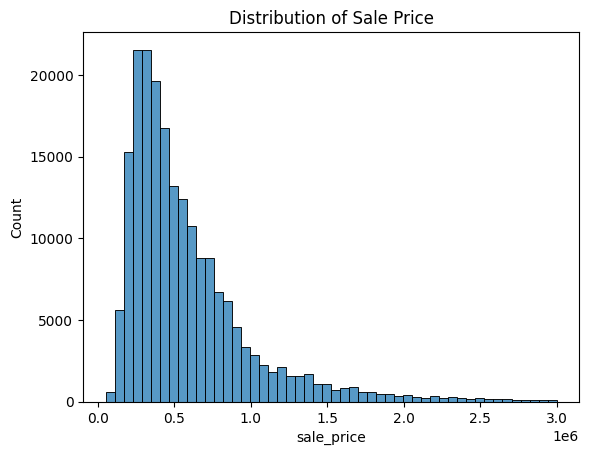

In [10]:
sns.histplot(unfiltered['sale_price'], bins=50)
plt.title('Distribution of Sale Price')

Text(0.5, 1.0, 'Sale Price vs Square Footage')

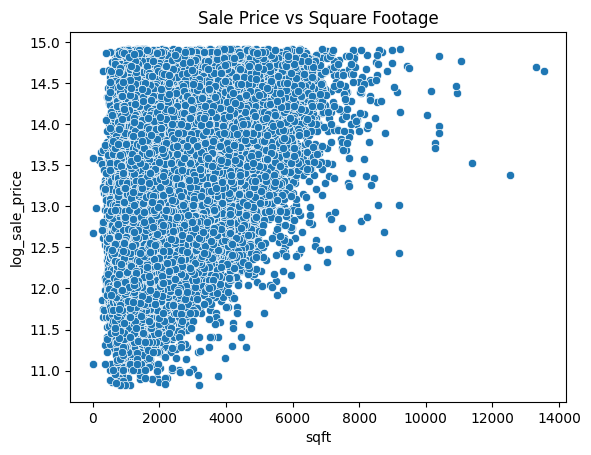

In [11]:
sns.scatterplot(x='sqft', y='log_sale_price', data=unfiltered)
plt.title('Sale Price vs Square Footage')

In [12]:
features = ['sale_year', 'grade', 'sqft', 'imp_val', 'land_val', 'total_bath', 'latitude', 'sqft_1', 'stories', 'bath_full', 'beds', 'view_territorial', 'sqft_fbsmt', 'bath_3qtr', 'fbmst_grade', 'view_lakewash', 
            'sale_nbr']

In [13]:
cat_cols = unfiltered.select_dtypes(include = ['object']).columns.tolist()
unfiltered[cat_cols] = OrdinalEncoder().fit_transform(unfiltered[cat_cols])

In [14]:
#Data splitting
X = unfiltered.drop(columns=['sale_price', 'log_sale_price'])
y = unfiltered['log_sale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
#LGBM model training and evaluation

model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert log predictions back to original scale
y_test_real = np.expm1(y_test)  # Convert log test values back to original scale

# Calculate RMSE and R^2
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test_real, y_pred_real)
print("R^2:", r2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4307
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 51
[LightGBM] [Info] Start training from score 13.079080
RMSE: 28437.239572411723
R^2: 0.995358884942533


Text(0.5, 1.0, 'Distribution of Prediction Errors')

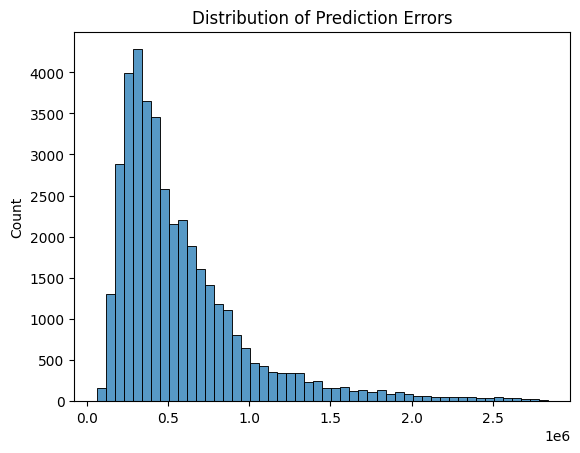

In [16]:
errors = y_test_real = y_pred_real
sns.histplot(errors, bins=50)
plt.title('Distribution of Prediction Errors')

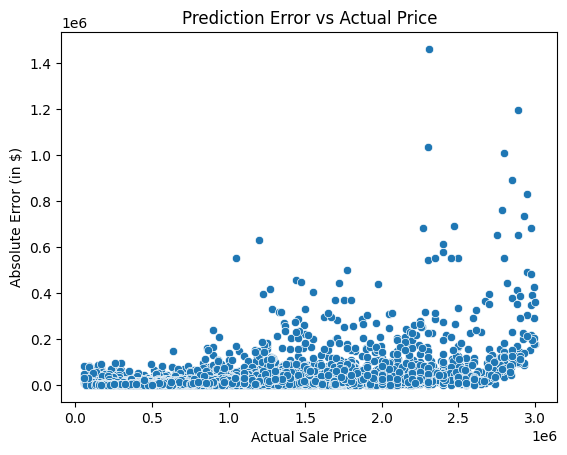

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert back to real prices if needed
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred)

# Plot absolute error in dollars
abs_error = np.abs(y_test_real - y_pred_real)

sns.scatterplot(x=y_test_real, y=abs_error)
plt.xlabel("Actual Sale Price")
plt.ylabel("Absolute Error (in $)")
plt.title("Prediction Error vs Actual Price")
plt.show()


In [18]:
unfiltered['price_bucket'] = pd.qcut(unfiltered['log_sale_price'], q=4, labels=False)

In [19]:
#New LGBM model with price bucket
X = unfiltered.drop(columns=['sale_price', 'log_sale_price'])
y = unfiltered['log_sale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert log predictions back to original scale
y_test_real = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
print("RMSE with Price Bucket:", rmse)
r2 = r2_score(y_test_real, y_pred_real)
print("R^2 with Price Bucket:", r2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4311
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 52
[LightGBM] [Info] Start training from score 13.079080
RMSE with Price Bucket: 33563.79229656806
R^2 with Price Bucket: 0.9935346876481469


In [20]:
unfiltered.drop(columns=['price_bucket'], inplace=True)

In [21]:
#Price bucket didn't work well, so we will not use it in the final model.
#Let's add is_luxury feature
unfiltered['is_luxury'] = (unfiltered['sale_price'] > 1100000).astype(int)

X = unfiltered.drop(columns=['sale_price', 'log_sale_price'])
y = unfiltered['log_sale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert log predictions back to original
# scale
y_test_real = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
print("RMSE with Luxury Feature:", rmse)
r2 = r2_score(y_test_real, y_pred_real)
print("R^2 with Luxury Feature:", r2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4309
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 52
[LightGBM] [Info] Start training from score 13.079080
RMSE with Luxury Feature: 28142.627518781523
R^2 with Luxury Feature: 0.9954545514448535


In [22]:
#Checking feature importance of luxury feature
importance = model.feature_importances_
features = X.columns.tolist()
for name, score in zip(features, importance):
    if "luxury" in name.lower():
        print(f"Feature: {name}, Importance: {score}")

Feature: is_luxury, Importance: 180


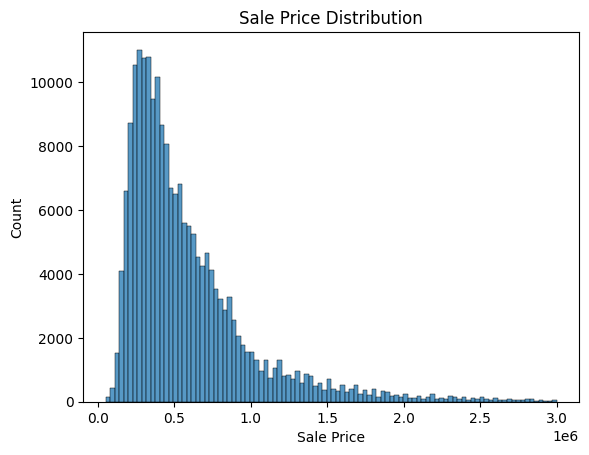

In [23]:
#Checking where upper market starts
sns.histplot(unfiltered['sale_price'], bins=100)
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.title("Sale Price Distribution")
plt.show()

In [24]:
percentiles = [0.5, 0.75, 0.90, 0.95, 0.99]
for p in percentiles:
    val = unfiltered['sale_price'].quantile(p)
    print(f"{int(p*100)}th percentile: ${val:,.0f}")

50th percentile: $459,950
75th percentile: $724,950
90th percentile: $1,100,000
95th percentile: $1,434,006
99th percentile: $2,250,000


RMSE for Luxury Homes: 85170.93650636436


Text(0.5, 1.0, 'Luxury Error vs Actual Price')

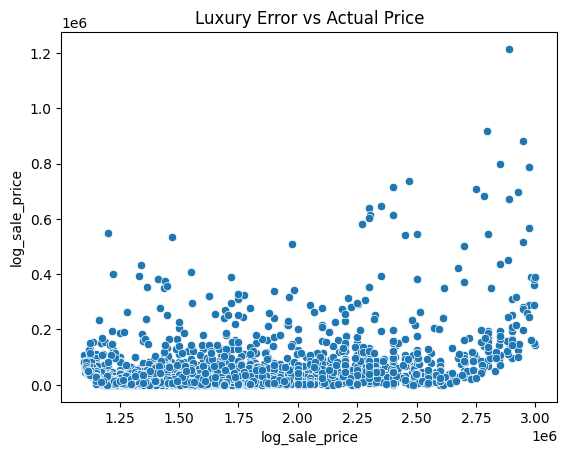

In [25]:
lux_mask = y_test_real > 1100000
lux_rmse = np.sqrt(mean_squared_error(y_test_real[lux_mask], y_pred_real[lux_mask]))
print("RMSE for Luxury Homes:", lux_rmse)
lux_data = unfiltered[unfiltered['is_luxury'] == 1]
sns.scatterplot(x=y_test_real[lux_mask], y=np.abs(y_test_real[lux_mask] - y_pred_real[lux_mask]))
plt.title("Luxury Error vs Actual Price")

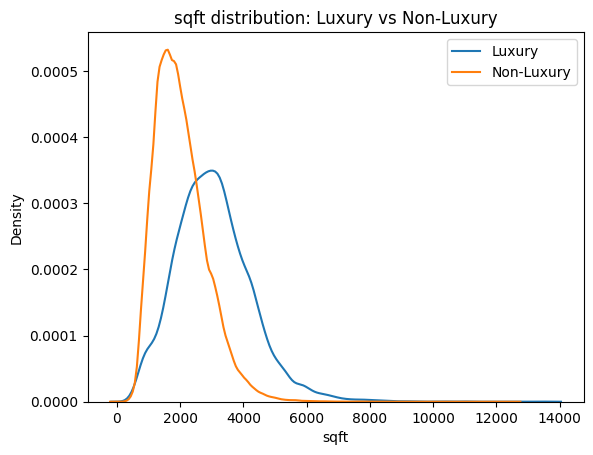

In [26]:
luxury_mask = unfiltered['is_luxury'] == 1

sns.kdeplot(unfiltered[luxury_mask]['sqft'], label='Luxury')
sns.kdeplot(unfiltered[~luxury_mask]['sqft'], label='Non-Luxury')
plt.title("sqft distribution: Luxury vs Non-Luxury")
plt.legend()
plt.show()


In [27]:
lux_df = unfiltered[unfiltered['is_luxury'] == 1]
X_lux = lux_df.drop(columns=['sale_price', 'log_sale_price'])
y_lux = lux_df['log_sale_price']

model_lux = lgb.LGBMRegressor()
model_lux.fit(X_lux, y_lux)

# Show feature importance
importances = model_lux.feature_importances_
feat_names = X_lux.columns

sorted_feats = sorted(zip(feat_names, importances), key=lambda x: -x[1])
for f, i in sorted_feats[:15]:
    print(f"{f}: {i}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4024
[LightGBM] [Info] Number of data points in the train set: 19374, number of used features: 51
[LightGBM] [Info] Start training from score 14.245891
price_per_sqft: 1157
sqft: 1141
sqft_1: 124
sqft_fbsmt: 72
imp_val: 46
land_val: 43
sale_date: 41
sqft_lot: 41
latitude: 38
longitude: 35
subdivision: 31
total_bath: 24
year_built: 21
grade: 21
age: 18


In [28]:
#Adding smart interaction features that amplify features luxury buyers care about
unfiltered['luxury_x_price_per_sqft'] = unfiltered['is_luxury'] * unfiltered['price_per_sqft']
unfiltered['luxury_x_sqft'] = unfiltered['is_luxury'] * unfiltered['sqft']
unfiltered['luxury_x_sqft_1'] = unfiltered['is_luxury'] * unfiltered['sqft_1']
unfiltered['luxury_x_subdivision'] = unfiltered['is_luxury'] * unfiltered['subdivision']
unfiltered['luxury_x_grade'] = unfiltered['is_luxury'] * unfiltered['grade']
unfiltered['luxury_x_total_bath'] = unfiltered['is_luxury'] * unfiltered['total_bath']


In [29]:
X = unfiltered.drop(columns=['sale_price', 'log_sale_price'])
y = unfiltered['log_sale_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert log predictions back to original scale
y_test_real = np.expm1(y_test)  # Convert log test values back to

# original scale
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
print("RMSE with Interaction Features:", rmse)
r2 = r2_score(y_test_real, y_pred_real)
print("R^2 with Interaction Features:", r2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5368
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 58
[LightGBM] [Info] Start training from score 13.079080
RMSE with Interaction Features: 17999.67495045514
R^2 with Interaction Features: 0.9981405830464061


In [30]:
#Adding an ultra luxury feature for the 99th percentile homes and higher
unfiltered['is_ultra_luxury'] = (unfiltered['sale_price'] > unfiltered['sale_price'].quantile(0.99)).astype(int)

In [31]:
ultra_mask = y_test_real > 2_250_000
ultra_rmse = mean_squared_error(
    y_test_real[ultra_mask],
    y_pred_real[ultra_mask],
) ** 0.5

X = unfiltered.drop(columns=['sale_price', 'log_sale_price'])
y = unfiltered['log_sale_price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert log predictions back to original
# scale
y_test_real = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
print("RMSE with Ultra Luxury Feature:", rmse)
r2 = r2_score(y_test_real, y_pred_real)
print("R^2 with Ultra Luxury Feature:", r2)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5370
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 59
[LightGBM] [Info] Start training from score 13.079080
RMSE with Ultra Luxury Feature: 20085.298143063348
R^2 with Ultra Luxury Feature: 0.9976847172982746


In [32]:
#Yikes, ultra luxury feature didn't help much, let's not use it in the final model.
#We will keep the luxury feature and the interaction features in the final model.
unfiltered.drop(columns=['is_ultra_luxury'], inplace=True)

In [33]:
#Trying different model: XGBoost

import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert log predictions back to original
# scale
y_test_real = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
print("XGBoost RMSE:", rmse)
r2 = r2_score(y_test_real, y_pred_real)
print("XGBoost R^2:", r2)

KeyboardInterrupt: 

In [ ]:
#Trying another model: Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth = 15, n_jobs = -1, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert log predictions back to original
# scale
y_test_real = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
print("RF RMSE:", rmse)
r2 = r2_score(y_test_real, y_pred_real)
print("RF R^2:", r2)

RF RMSE: 7939.803163527045
RF R^2: 0.9996382013571551


In [ ]:
from catboost import CatBoostRegressor
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    random_seed=42,
    loss_function ='RMSE',
    verbose=0
)
cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert log predictions back to original scale
y_test_real = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
print("CatBoost RMSE:", rmse)
r2 = r2_score(y_test_real, y_pred_real)
print("CatBoost R^2:", r2)


CatBoost RMSE: 12444.459459242504
CatBoost R^2: 0.9991112092296156


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

for train_idx, val_idx in kf.split(X):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]  # assume log_sale_price

    rf_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = rf_model.predict(X_val_cv)

    # Exponentiate back to real $ scale
    y_val_real = np.expm1(y_val_cv)
    y_pred_real = np.expm1(y_pred_cv)

    mse = mean_squared_error(y_val_real, y_pred_real)
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)

print("CV RMSEs (real $):", rmse_scores)
print("Avg CV RMSE (real $):", np.mean(rmse_scores))


CV RMSEs (real $): [np.float64(8039.77263286814), np.float64(7046.51195922395), np.float64(8254.258740785346), np.float64(8208.716784208142), np.float64(8655.351095854296)]
Avg CV RMSE (real $): 8040.922242587975


In [ ]:
rmse_scores = np.array(rmse_scores)**0.5
print("CV RMSEs (real $):", rmse_scores)
print("Avg CV RMSE (real $):", np.mean(rmse_scores))

CV RMSEs (real $): [89.66477922 83.94350457 90.85295119 90.60196899 93.03413941]
Avg CV RMSE (real $): 89.61946867632557


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.8, None]
}
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))
rmse_scorer = make_scorer(rmse_score, greater_is_better=False)

search = RandomizedSearchCV(
    estimator = RandomForestRegressor(n_jobs=-1, random_state=42),
    param_distributions = param_grid,
    n_iter = 30,
    cv = 3,
    scoring=rmse_scorer,
    verbose=2,
    random_state=42)
search.fit(X_train, y_train)

best_rf = search.best_estimator_
y_pred = best_rf.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert log predictions back to original scale
y_test_real = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
print("Best RF RMSE:", rmse)
r2 = r2_score(y_test_real, y_pred_real)
print("Best RF R^2:", r2)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END max_depth=15, max_features=0.8, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  34.3s
[CV] END max_depth=15, max_features=0.8, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  38.3s
[CV] END max_depth=15, max_features=0.8, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  39.7s
[CV] END max_depth=15, max_features=0.8, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  43.5s
[CV] END max_depth=15, max_features=0.8, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  37.9s
[CV] END max_depth=15, max_features=0.8, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  39.4s
[CV] END max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.4min
[CV] END max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; t

In [ ]:
print("Best Params: ", search.best_params_)

Best Params:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}


In [ ]:
import joblib
joblib.dump(best_rf, 'best_rf_model.pkl')

['best_rf_model.pkl']

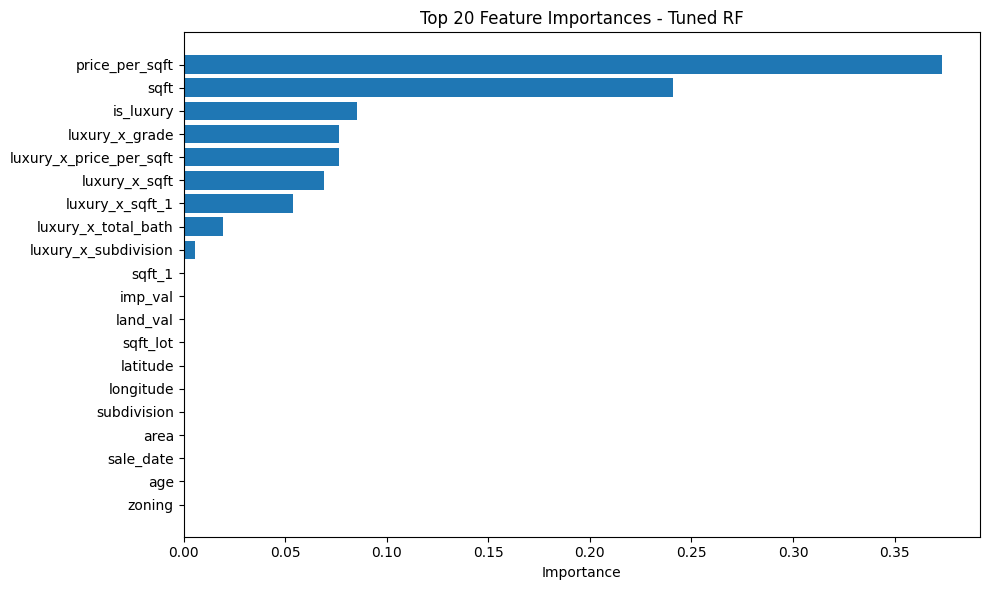

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

importances = best_rf.feature_importances_
features = X_train.columns
fi_df = pd.DataFrame({'feature': features, 'importance': importances})
fi_df = fi_df.sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances - Tuned RF")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
#Need to retrain for submission because we can't use anything that relates to sale_price
unfiltered_2 = pd.read_csv('../data/dataset.csv')
unfiltered_2.columns

Index(['id', 'sale_date', 'sale_price', 'sale_nbr', 'sale_warning',
       'join_status', 'join_year', 'latitude', 'longitude', 'area', 'city',
       'zoning', 'subdivision', 'present_use', 'land_val', 'imp_val',
       'year_built', 'year_reno', 'sqft_lot', 'sqft', 'sqft_1', 'sqft_fbsmt',
       'grade', 'fbsmt_grade', 'condition', 'stories', 'beds', 'bath_full',
       'bath_3qtr', 'bath_half', 'garb_sqft', 'gara_sqft', 'wfnt', 'golf',
       'greenbelt', 'noise_traffic', 'view_rainier', 'view_olympics',
       'view_cascades', 'view_territorial', 'view_skyline', 'view_sound',
       'view_lakewash', 'view_lakesamm', 'view_otherwater', 'view_other',
       'submarket'],
      dtype='object')

In [36]:
#Initial Datapreprocessing
unfiltered_2 = unfiltered_2.drop(columns=['id'])
unfiltered_2['Salenumber_missing'] = unfiltered_2['sale_nbr'].isnull().astype(int)
unfiltered_2['sale_nbr'] = unfiltered_2['sale_nbr'].fillna(-1)

unfiltered_2['subdivision'] = unfiltered_2['subdivision'].fillna('Unknown')
unfiltered_2['submarket'] = unfiltered_2['submarket'].fillna('Unknown')

unfiltered_2['sqft'].replace(0, np.nan)
unfiltered_2['age'] = unfiltered_2['sale_date'].str[:4].astype(int) - unfiltered_2['year_built']
unfiltered_2['year_reno'].sort_values(ascending=False).unique()

unfiltered_2['sale_year'] = unfiltered_2['sale_date'].str[:4].astype(int)
unfiltered_2['reno_age'] = np.where(
    (unfiltered_2['year_reno'] == 0) | (unfiltered_2['year_reno'] > unfiltered['sale_year']), -1,
    unfiltered_2['sale_year'] - unfiltered_2['year_reno']
)

unfiltered_2['log_sale_price'] = np.log1p(unfiltered_2['sale_price'])
unfiltered_2['total_bath'] = unfiltered_2['bath_full'] + unfiltered_2['bath_half'] * 0.5 + unfiltered_2['bath_3qtr'] * 0.75

cat_cols = unfiltered_2.select_dtypes(include = ['object']).columns.tolist()
unfiltered_2[cat_cols] = OrdinalEncoder().fit_transform(unfiltered_2[cat_cols])

In [37]:
luxury_feats = ['sqft', 'sqft_1', 'sqft_fbsmt', 'imp_val', 'land_val', 'grade', 
                'fbsmt_grade', 'stories', 'total_bath', 'gara_sqft']
unfiltered_2[luxury_feats].describe(percentiles=[.5, .75, .9, .95, .99])

,sqft,sqft_1,sqft_fbsmt,imp_val,land_val,grade,fbsmt_grade,stories,total_bath,gara_sqft
count,200000.000000,200000.000000,200000.000000,2.000000e+05,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,2120.679850,1251.284280,293.238535,4.917715e+05,4.601691e+05,7.667290,2.811045,1.523778,2.196831,274.151470
std,909.799433,468.094648,443.577947,3.680505e+05,3.510444e+05,1.153746,3.556495,0.526367,0.761216,288.338763
min,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000,0.000000,0.000000
50%,1970.000000,1200.000000,0.000000,4.090000e+05,3.770000e+05,7.000000,0.000000,1.500000,2.250000,240.000000
75%,2610.000000,1470.000000,570.000000,5.990000e+05,5.940000e+05,8.000000,7.000000,2.000000,2.500000,480.000000
90%,3310.000000,1810.000000,970.000000,9.330000e+05,8.620000e+05,9.000000,8.000000,2.000000,3.250000,660.000000
95%,3790.000000,2080.000000,1190.000000,1.202000e+06,1.052000e+06,10.000000,8.000000,2.000000,3.500000,760.000000
99%,4900.000000,2780.000000,1660.000000,1.780000e+06,1.709010e+06,11.000000,10.000000,3.000000,4.250000,970.000000
max,13540.000000,7760.000000,5480.000000,1.006700e+07,1.386400e+07,13.000000,13.000000,4.500000,11.750000,4404.000000


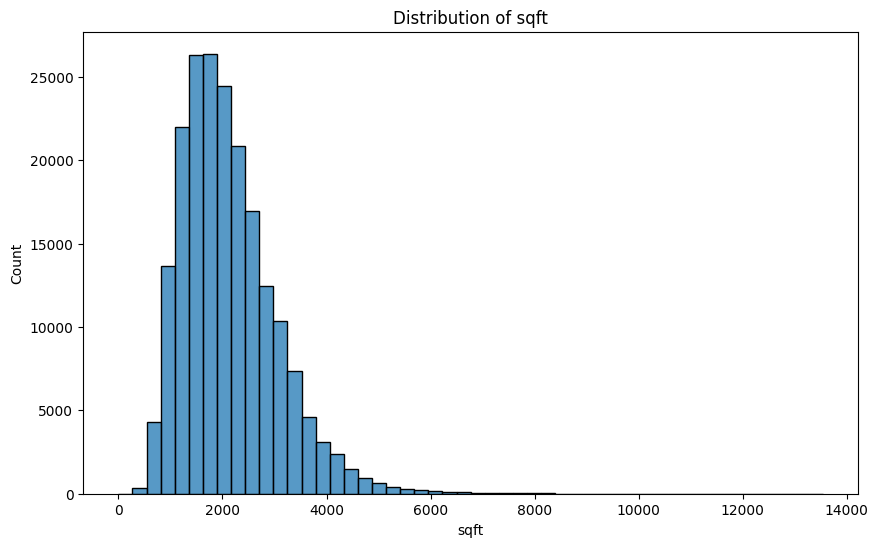

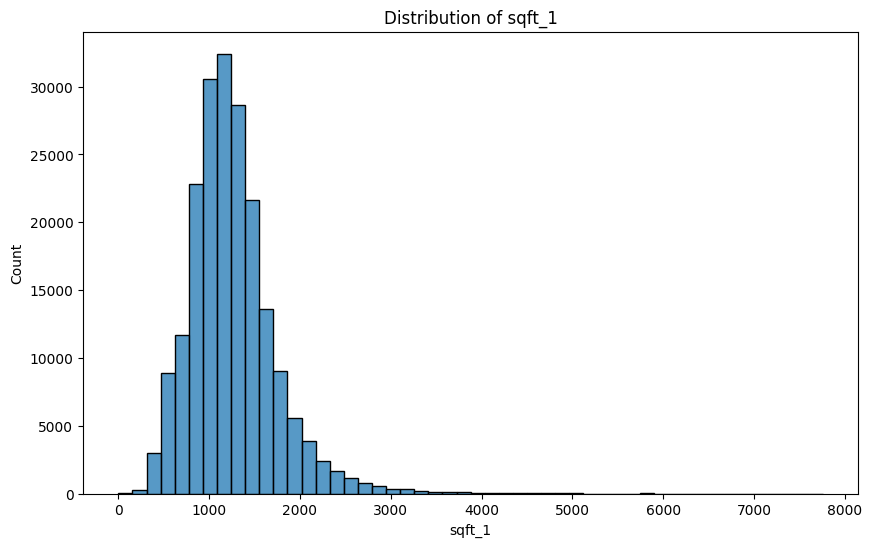

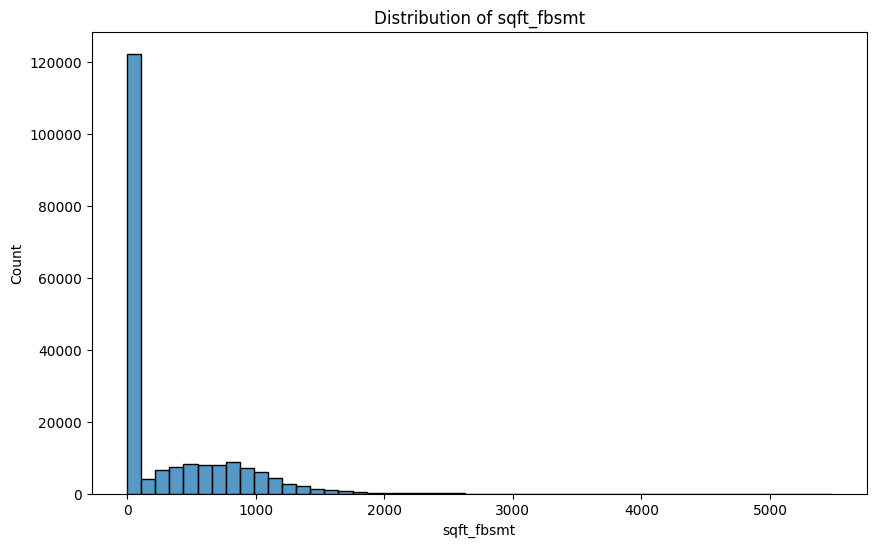

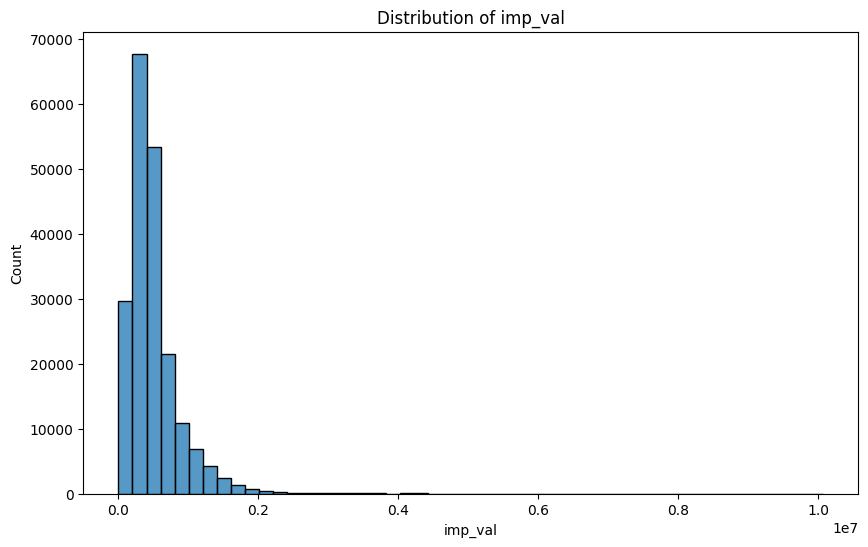

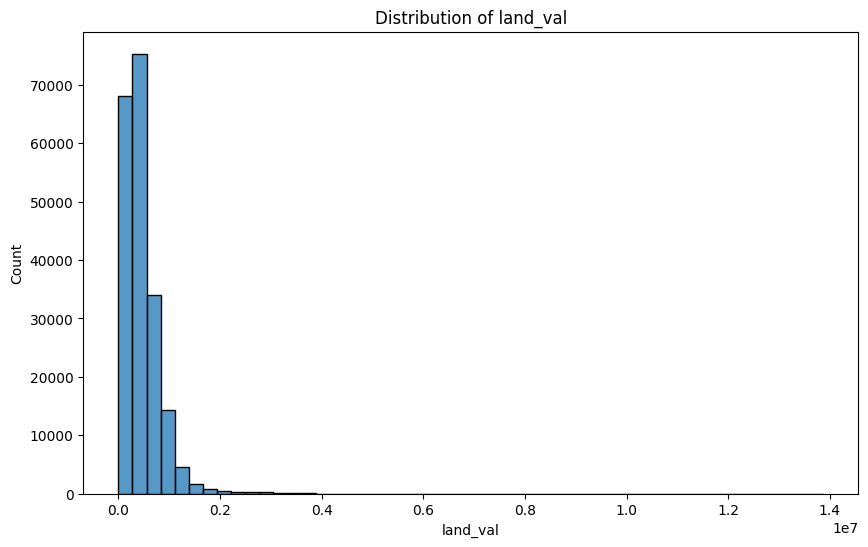

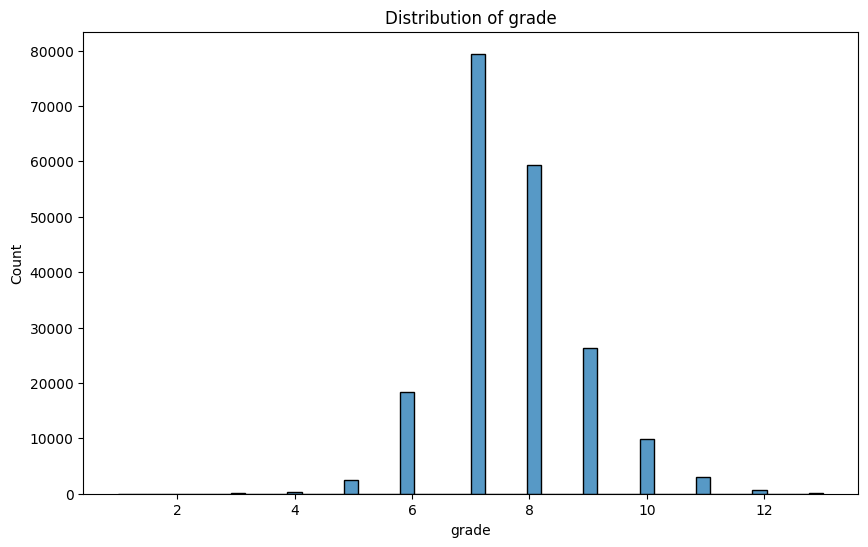

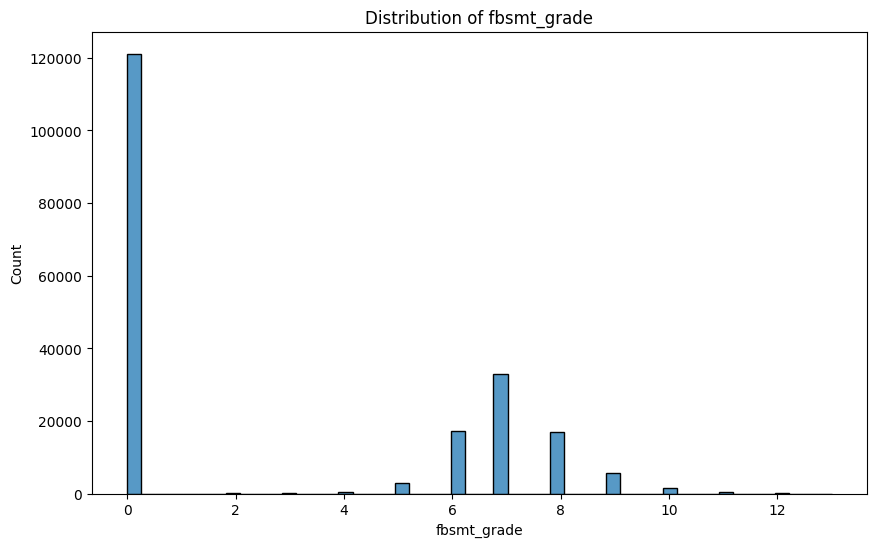

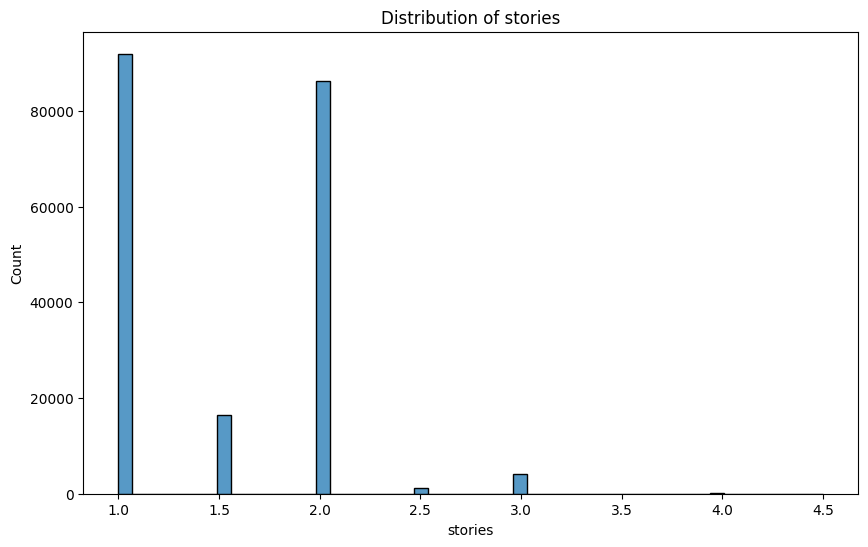

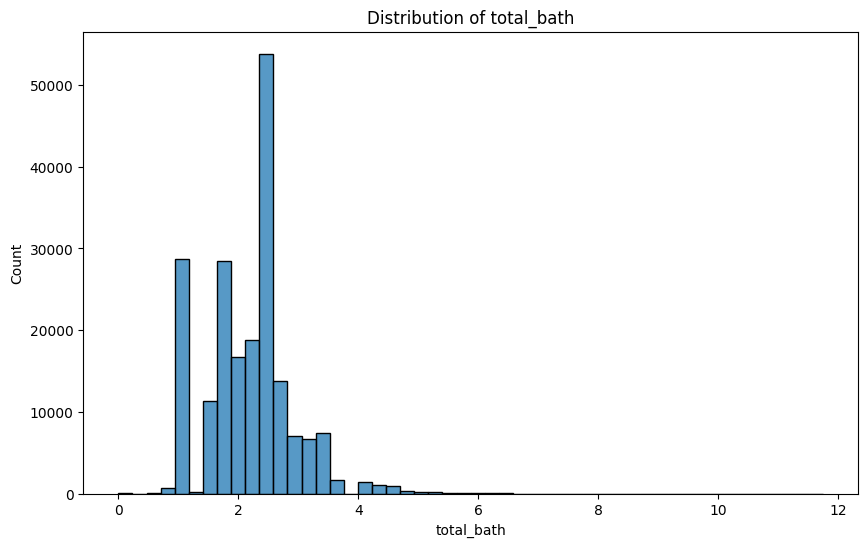

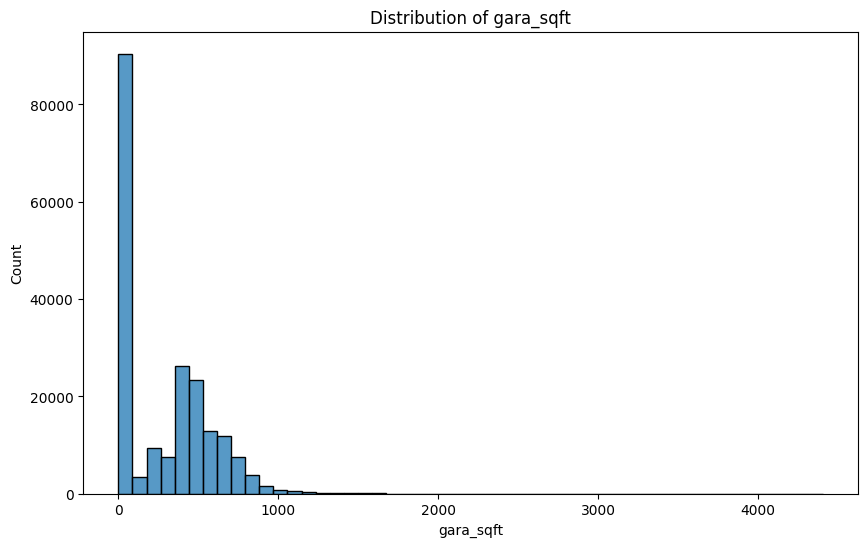

In [38]:
for col in luxury_feats:
    plt.figure(figsize=(10, 6))
    sns.histplot(unfiltered_2[col], bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

In [39]:
#Finding if something is luxury or not
#Luxury homes are defined by a combination of features that indicate high value and desirability.
luxury_rules = (
    (unfiltered_2['sqft'] > 3800).astype(int) +
    (unfiltered_2['imp_val'] > 1_200_000).astype(int) +
    (unfiltered_2['land_val'] > 1_000_000).astype(int) +
    (unfiltered_2['grade'] >= 10).astype(int) +
    (unfiltered_2['total_bath'] > 3.5).astype(int) +
    (unfiltered_2['gara_sqft'] > 750).astype(int)
)

unfiltered_2['is_luxury'] = (luxury_rules >= 3).astype(int)


In [40]:
#Adding other luxury interaction features that amplify features luxury buyers care about
unfiltered_2['luxury_x_sqft'] = unfiltered_2['is_luxury'] * unfiltered_2['sqft']
unfiltered_2['luxury_x_sqft_1'] = unfiltered_2['is_luxury'] * unfiltered_2['sqft_1']
unfiltered_2['luxury_x_subdivision'] = unfiltered_2['is_luxury'] * unfiltered_2['subdivision']
unfiltered_2['luxury_x_grade'] = unfiltered_2['is_luxury'] * unfiltered_2['grade']
unfiltered_2['luxury_x_total_bath'] = unfiltered_2['is_luxury'] * unfiltered_2['total_bath']

In [41]:
#Retrying with new model with random forest
X = unfiltered_2.drop(columns=['sale_price', 'log_sale_price'])
y = unfiltered_2['log_sale_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert log predictions back to original scale
y_test_real = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
print("Final Model RMSE:", rmse)
r2 = r2_score(y_test_real, y_pred_real)
print("Final Model R^2:", r2)

NameError: name 'RandomForestRegressor' is not defined

In [42]:
importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'feature': features, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df.head(20))

plt.figure(figsize=(10, 6))
plt.barh(importance_df.head(20)['feature'][::-1], importance_df.head(20)['importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - First Test Random Forest Model')
plt.tight_layout()
plt.show()

NameError: name 'rf_model' is not defined

In [43]:
#Redoing the is_luxury feature
# Use the original training data (with sale_price) to get the 90th percentile thresholds
luxury_cutoffs = {
    'sqft': unfiltered_2['sqft'].quantile(0.9),
    'grade': unfiltered_2['grade'].quantile(0.9),
    'imp_val': unfiltered_2['imp_val'].quantile(0.9),
    'total_bath': unfiltered_2['total_bath'].quantile(0.9)
}

# Now use these rules to create is_luxury
unfiltered_2['is_luxury'] = (
    (unfiltered_2['sqft'] >= luxury_cutoffs['sqft']) |
    (unfiltered_2['grade'] >= luxury_cutoffs['grade']) |
    (unfiltered_2['imp_val'] >= luxury_cutoffs['imp_val']) |
    (unfiltered_2['total_bath'] >= luxury_cutoffs['total_bath'])
).astype(int)

unfiltered_2['luxury_x_sqft'] = unfiltered_2['is_luxury'] * unfiltered_2['sqft']
unfiltered_2['luxury_x_sqft_1'] = unfiltered_2['is_luxury'] * unfiltered_2['sqft_1']
unfiltered_2['luxury_x_subdivision'] = unfiltered_2['is_luxury'] * unfiltered_2['subdivision']
unfiltered_2['luxury_x_grade'] = unfiltered_2['is_luxury'] * unfiltered_2['grade']
unfiltered_2['luxury_x_total_bath'] = unfiltered_2['is_luxury'] * unfiltered_2['total_bath']


In [44]:
#Retrying with new model with adjusted is_luxury feature
X = unfiltered_2.drop(columns=['sale_price', 'log_sale_price'])
y = unfiltered_2['log_sale_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert log predictions back to original scale
y_test_real = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
print("Final Model RMSE:", rmse)
r2 = r2_score(y_test_real, y_pred_real)
print("Final Model R^2:", r2)

NameError: name 'RandomForestRegressor' is not defined

In [45]:
luxury_feats = ['sqft', 'grade', 'imp_val', 'total_bath']
luxury_cutoffs = {col: unfiltered[col].quantile(0.9) for col in luxury_feats}

# Count how many luxury conditions are met
unfiltered_2['luxury_score'] = sum(
    (unfiltered_2[col] >= luxury_cutoffs[col]).astype(int)
    for col in luxury_feats
)

# Only label as luxury if at least 2 or 3 traits are above 90th percentile
unfiltered_2['is_luxury'] = (unfiltered_2['luxury_score'] >= 2).astype(int)

unfiltered_2['luxury_x_sqft'] = unfiltered_2['is_luxury'] * unfiltered_2['sqft']
unfiltered_2['luxury_x_sqft_1'] = unfiltered_2['is_luxury'] * unfiltered_2['sqft_1']
unfiltered_2['luxury_x_subdivision'] = unfiltered_2['is_luxury'] * unfiltered_2['subdivision']
unfiltered_2['luxury_x_grade'] = unfiltered_2['is_luxury'] * unfiltered_2['grade']
unfiltered_2['luxury_x_total_bath'] = unfiltered_2['is_luxury'] * unfiltered_2['total_bath']



In [46]:
#Retrying with new model with adjusted is_luxury feature
X = unfiltered_2.drop(columns=['sale_price', 'log_sale_price'])
y = unfiltered_2['log_sale_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert log predictions back to original scale
y_test_real = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
print("Final Model RMSE:", rmse)
r2 = r2_score(y_test_real, y_pred_real)
print("Final Model R^2:", r2)

NameError: name 'RandomForestRegressor' is not defined

In [47]:
#Doing some more EDA to figure out how to fix our model
errors = pd.DataFrame({
    'actual': np.expm1(y_test),
    'predicted': np.expm1(y_pred),
})
errors['residual'] = errors['actual'] - errors['predicted']
errors['pct_error'] = errors['residual'] / errors['actual']

# Sort worst predictions
errors.sort_values(by='residual', key=abs, ascending=False).head(20)


,actual,predicted,residual,pct_error
100476,2400000.0,1.762826e+06,637173.745828,0.265489
150001,2294000.0,2.795077e+06,-501077.149885,-0.218429
168841,1270000.0,1.738285e+06,-468285.339516,-0.368729
25222,2995600.0,2.598375e+06,397225.362138,0.132603
87044,2285000.0,2.675890e+06,-390889.545456,-0.171068
79350,2350000.0,2.730636e+06,-380636.214616,-0.161973
46227,2975000.0,2.602452e+06,372547.905760,0.125226
87677,2920000.0,2.554683e+06,365317.149824,0.125109
18812,2300000.0,2.662788e+06,-362787.641608,-0.157734
128537,2891000.0,2.534521e+06,356478.947237,0.123306


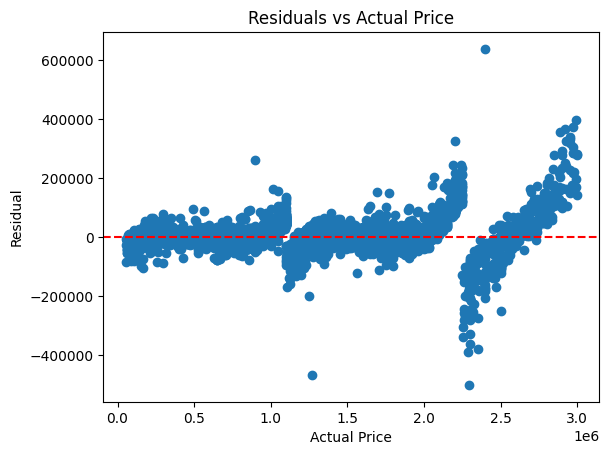

In [48]:
plt.scatter(errors['actual'], errors['residual'])
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Residual')
plt.title('Residuals vs Actual Price')
plt.show()


In [49]:
#Resetting to the best is_luxury feature
# Use the original training data (with sale_price) to get the 90th percentile thresholds
luxury_cutoffs = {
    'sqft': unfiltered_2['sqft'].quantile(0.9),
    'grade': unfiltered_2['grade'].quantile(0.9),
    'imp_val': unfiltered_2['imp_val'].quantile(0.9),
    'total_bath': unfiltered_2['total_bath'].quantile(0.9)
}

# Now use these rules to create is_luxury
unfiltered_2['is_luxury'] = (
    (unfiltered_2['sqft'] >= luxury_cutoffs['sqft']) |
    (unfiltered_2['grade'] >= luxury_cutoffs['grade']) |
    (unfiltered_2['imp_val'] >= luxury_cutoffs['imp_val']) |
    (unfiltered_2['total_bath'] >= luxury_cutoffs['total_bath'])
).astype(int)

unfiltered_2['luxury_x_sqft'] = unfiltered_2['is_luxury'] * unfiltered_2['sqft']
unfiltered_2['luxury_x_sqft_1'] = unfiltered_2['is_luxury'] * unfiltered_2['sqft_1']
unfiltered_2['luxury_x_subdivision'] = unfiltered_2['is_luxury'] * unfiltered_2['subdivision']
unfiltered_2['luxury_x_grade'] = unfiltered_2['is_luxury'] * unfiltered_2['grade']
unfiltered_2['luxury_x_total_bath'] = unfiltered_2['is_luxury'] * unfiltered_2['total_bath']


In [61]:
# Only on train data!
q_low = unfiltered_2['log_sale_price'].quantile(0.005)
q_high = unfiltered_2['log_sale_price'].quantile(0.995)

train_filtered = unfiltered_2[(unfiltered_2['log_sale_price'] >= q_low) & (unfiltered_2['log_sale_price'] <= q_high)]

In [62]:
train_filtered.columns

Index(['sale_date', 'sale_price', 'sale_nbr', 'sale_warning', 'join_status',
       'join_year', 'latitude', 'longitude', 'area', 'city', 'zoning',
       'subdivision', 'present_use', 'land_val', 'imp_val', 'year_built',
       'year_reno', 'sqft_lot', 'sqft', 'sqft_1', 'sqft_fbsmt', 'grade',
       'fbsmt_grade', 'condition', 'stories', 'beds', 'bath_full', 'bath_3qtr',
       'bath_half', 'garb_sqft', 'gara_sqft', 'wfnt', 'golf', 'greenbelt',
       'noise_traffic', 'view_rainier', 'view_olympics', 'view_cascades',
       'view_territorial', 'view_skyline', 'view_sound', 'view_lakewash',
       'view_lakesamm', 'view_otherwater', 'view_other', 'submarket',
       'Salenumber_missing', 'age', 'sale_year', 'reno_age', 'log_sale_price',
       'total_bath', 'is_luxury', 'luxury_x_sqft', 'luxury_x_sqft_1',
       'luxury_x_subdivision', 'luxury_x_grade', 'luxury_x_total_bath',
       'luxury_score'],
      dtype='object')

In [51]:
#Retrying with new model with no outliers and adjusted is_luxury 
X = train_filtered.drop(columns=['sale_price', 'log_sale_price'])
y = train_filtered['log_sale_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert log predictions back to original scale
y_test_real = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
print("Final Model RMSE:", rmse)
r2 = r2_score(y_test_real, y_pred_real)
print("Final Model R^2:", r2)

NameError: name 'RandomForestRegressor' is not defined

In [52]:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

# Define luxury features
luxury_feats = ['sqft', 'sqft_1', 'imp_val', 'land_val', 'grade', 'total_bath']

# Ensure train_filtered is a proper copy
train_filtered = train_filtered.copy()

# Create normalized luxury_score
scaler = MinMaxScaler()
train_filtered.loc[:, 'luxury_score'] = scaler.fit_transform(train_filtered[luxury_feats]).sum(axis=1)

# Create luxury interaction terms
for col in luxury_feats:
    train_filtered.loc[:, f'luxury_x_{col}'] = train_filtered['luxury_score'] * train_filtered[col].astype(float)


C:\Users\ahsan\AppData\Local\Temp\ipykernel_93752\3390106765.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.01401096 1.14400225 0.99133128 ... 0.98385662 1.20285722 0.95079904]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_filtered.loc[:, 'luxury_score'] = scaler.fit_transform(train_filtered[luxury_feats]).sum(axis=1)
C:\Users\ahsan\AppData\Local\Temp\ipykernel_93752\3390106765.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1581.85709547 2333.76458253 1625.78329663 ... 1662.71768734 2501.94302494
 1255.0547337 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_filtered.loc[:, f'luxury_x_{col}'] = train_filtered['luxury_score'] * train_filtered[col].astype(float)
C:\Users\ahsan\AppData\Local\Temp\ipykernel_93752\3390106765.py:15: Futu

In [53]:
X = train_filtered.drop(columns=['sale_price', 'log_sale_price'])
y = train_filtered['log_sale_price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert log predictions back to original
# scale
y_test_real = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
print("RF Model with Dynamic Luxury Score:", rmse)
r2 = r2_score(y_test_real, y_pred_real)
print("RF Model R^2 with Dynamic Luxury Score:", r2)

NameError: name 'RandomForestRegressor' is not defined

In [54]:
X = train_filtered.drop(columns=['sale_price', 'log_sale_price'])
y = train_filtered['log_sale_price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert log predictions back to original scale
y_test_real = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
print("LGBM Model with Dynamic Luxury Score RMSE:", rmse)
r2 = r2_score(y_test_real, y_pred_real)
print("LGBM Model R^2 with Dynamic Luxury Score:", r2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6086
[LightGBM] [Info] Number of data points in the train set: 158418, number of used features: 59
[LightGBM] [Info] Start training from score 13.078992
LGBM Model with Dynamic Luxury Score RMSE: 106230.14251226868
LGBM Model R^2 with Dynamic Luxury Score: 0.9244417924257082


In [55]:
X = train_filtered.drop(columns=['sale_price', 'log_sale_price'])
y = train_filtered['log_sale_price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
y_pred_real_lgbm = np.expm1(y_pred)  # Convert log predictions back to original
# scale
y_test_real_lgbm = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real_lgbm, y_pred_real_lgbm)
rmse = np.sqrt(mse)
print("LGBM Model with Dynamic Luxury Score RMSE:", rmse)
r2 = r2_score(y_test_real_lgbm, y_pred_real_lgbm)
print("LGBM Model R^2 with Dynamic Luxury Score:", r2)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6086
[LightGBM] [Info] Number of data points in the train set: 158418, number of used features: 59
[LightGBM] [Info] Start training from score 13.078992


KeyboardInterrupt: 

In [56]:
X = train_filtered.drop(columns=['sale_price', 'log_sale_price'])
y = train_filtered['log_sale_price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs = -1
)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_pred_real_xgb = np.expm1(y_pred)  # Convert log predictions back to original scale
y_test_real_xgb = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real_xgb, y_pred_real_xgb)
rmse = np.sqrt(mse)
print("XGBoost Model with Dynamic Luxury Score RMSE:", rmse)
r2 = r2_score(y_test_real_xgb, y_pred_real_xgb)
print("XGBoost Model R^2 with Dynamic Luxury Score:", r2)

XGBoost Model with Dynamic Luxury Score RMSE: 95454.52424602919
XGBoost Model R^2 with Dynamic Luxury Score: 0.9389930724491586


In [125]:
original_train = unfiltered_2.copy()
original_cat_cols = original_train.select_dtypes(include=['object']).columns.tolist()
categorical_feature_indices = [original_train.columns.get_loc(col) for col in original_cat_cols]

cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    random_seed=42,
    loss_function='RMSE',
    verbose=0,
    cat_features=categorical_feature_indices
)
cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
y_pred_real_cat = np.expm1(y_pred)  # Convert log predictions back to original scale
y_test_real_cat = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real_cat, y_pred_real_cat)
rmse = np.sqrt(mse)
print("CatBoost Model with Dynamic Luxury Score RMSE:", rmse)
r2 = r2_score(y_test_real_cat, y_pred_real_cat)
print("CatBoost Model R^2 with Dynamic Luxury Score:", r2)

CatBoost Model with Dynamic Luxury Score RMSE: 94687.27184941543
CatBoost Model R^2 with Dynamic Luxury Score: 0.9399698641573286


In [126]:
y_pred_real_avg = (y_pred_real_xgb + y_pred_real_lgbm + y_pred_real_cat) / 3
final_rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real_avg))
final_r2 = r2_score(y_test_real, y_pred_real_avg)
print("Ensemble RMSE:", final_rmse)
print("Ensemble R^2:", final_r2)

Ensemble RMSE: 93268.93816988611
Ensemble R^2: 0.9417547942585905


In [59]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

xgb_param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [1, 1.5, 2]
}

xgb_search = RandomizedSearchCV(
    estimator = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42),
    param_distributions=xgb_param_grid,
    n_iter=30,
    cv=3,
    scoring="neg_root_mean_squared_error",
    verbose=2,
    random_state=42
)

xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.7; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.7; total time=   3.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.7; total time=   5.4s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_est

In [60]:
y_pred = best_xgb.predict(X_test)
y_pred_real_xgb_best = np.expm1(y_pred)  # Convert log predictions
# back to original scale
y_test_real_xgb_best = np.expm1(y_test)  # Convert log test
# values back to original scale
mse = mean_squared_error(y_test_real_xgb_best, y_pred_real_xgb_best)
rmse = np.sqrt(mse)
print("Best XGBoost Model RMSE:", rmse)
r2 = r2_score(y_test_real_xgb_best, y_pred_real_xgb_best)
print("Best XGBoost Model R^2:", r2)

Best XGBoost Model RMSE: 94729.69447507962
Best XGBoost Model R^2: 0.9399160616469211


In [134]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

lgbm_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 50],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

lgbm_search = RandomizedSearchCV(
    estimator=LGBMRegressor(n_jobs=-1, random_state=42),
    param_distributions=lgbm_param_grid,
    n_iter=30,
    cv=3,
    scoring=rmse_scorer,  # already defined before
    verbose=2,
    random_state=42
)

lgbm_search.fit(X_train, y_train)
best_lgbm = lgbm_search.best_estimator_

# Evaluate
y_pred = best_lgbm.predict(X_test)
y_pred_real = np.expm1(y_pred)
y_test_real = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2 = r2_score(y_test_real, y_pred_real)
print("Best LGBM Model RMSE:", rmse)
print("Best LGBM Model R^2:", r2)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8084
[LightGBM] [Info] Number of data points in the train set: 105612, number of used features: 67
[LightGBM] [Info] Start training from score 13.078617
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_samples=30, n_estimators=100, num_leaves=20, reg_alpha=0, reg_lambda=0, subsample=0.6; total time=   1.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8082
[LightGBM] [Info] Number of data points in the train set: 105612, number of used features: 67
[LightGBM] [Info] Start training from score 13.077232
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_chi

Text(0.5, 1.0, 'Log Sale Price Distribution')

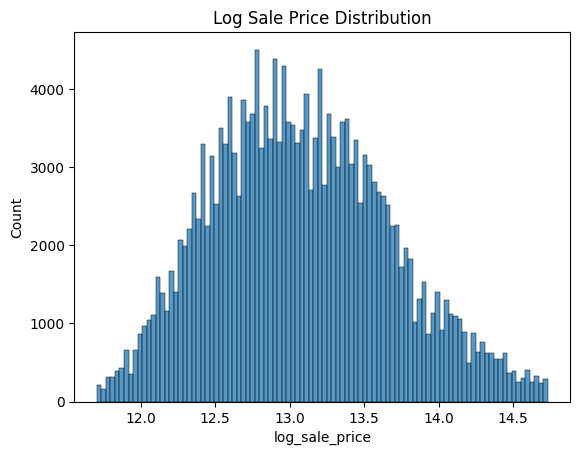

In [146]:
#Need to do some more eda because this just isn't doing well
sns.histplot(train_filtered['log_sale_price'], bins=100)
plt.title("Log Sale Price Distribution")

In [144]:
print(train_filtered['sale_price'].describe())
print(train_filtered['log_sale_price'].describe())

count    1.980230e+05
mean     5.760390e+05
std      3.895700e+05
min      1.214000e+05
25%      3.065000e+05
50%      4.599500e+05
75%      7.200000e+05
max      2.500000e+06
Name: sale_price, dtype: float64
count    198023.000000
mean         13.077718
std           0.597944
min          11.706854
25%          12.632976
50%          13.038875
75%          13.487008
max          14.731802
Name: log_sale_price, dtype: float64


In [ ]:
correlations = train_filtered.corr(numeric_only=True)['log_sale_price'].sort_values(ascending=False)
print(correlations)

log_sale_price                  1.000000
sale_price                      0.932103
sale_year                       0.619488
sale_date                       0.619351
luxury_x_grade                  0.514133
luxury_score_x_grade            0.514133
luxury_score                    0.513712
grade                           0.492813
sqft                            0.477475
luxury_x_sqft                   0.476752
luxury_score_x_sqft             0.476752
luxury_score_x_total_bath       0.454638
luxury_x_total_bath             0.454638
imp_val                         0.447045
is_luxury                       0.431603
luxury_x_imp_val                0.423559
luxury_score_x_imp_val          0.423559
luxury_x_land_val               0.416963
luxury_score_x_land_val         0.416963
land_val                        0.396327
luxury_score_x_sqft_1           0.389474
luxury_x_sqft_1                 0.389474
total_bath                      0.383901
luxury_x_subdivision            0.363190
latitude        

In [156]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_train_top, y_train, n_repeats=10, random_state=42, scoring='r2')

# Get sorted importances
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:20]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f}")


sale_nbr: 0.6290
condition: 0.1575
present_use: 0.1499
year_reno: 0.1481
sqft: 0.0678
sale_date: 0.0346
area: 0.0299
longitude: 0.0150
grade: 0.0132
stories: 0.0123
latitude: 0.0089
sqft_1: 0.0081
imp_val: 0.0072
join_year: 0.0056
beds: 0.0053
zoning: 0.0043
fbsmt_grade: 0.0024
land_val: 0.0000
sqft_lot: 0.0000


In [57]:
# 🔹1. Interaction terms
train_filtered['sqft_x_grade'] = train_filtered['sqft'] * train_filtered['grade']
train_filtered['imp_val_per_sqft'] = train_filtered['imp_val'] / (train_filtered['sqft'] + 1)
train_filtered['land_val_per_sqft'] = train_filtered['land_val'] / (train_filtered['sqft'] + 1)
train_filtered['bath_per_bed'] = train_filtered['total_bath'] / (train_filtered['beds'] + 1)

# 🔹2. Renovation & age flags
train_filtered['recent_reno'] = ((train_filtered['reno_age'] >= 0) & (train_filtered['reno_age'] < 5)).astype(int)
train_filtered['new_build'] = (train_filtered['age'] <= 2).astype(int)
train_filtered['is_old'] = (train_filtered['age'] >= 50).astype(int)

# 🔹3. View feature: total number of water/mountain/city views
view_cols = [col for col in train_filtered.columns if col.startswith("view_")]
train_filtered['num_views'] = train_filtered[view_cols].sum(axis=1)

# 🔹4. Geographic interactions
train_filtered['luxury_lat'] = train_filtered['latitude'] * train_filtered['is_luxury']
train_filtered['luxury_lon'] = train_filtered['longitude'] * train_filtered['is_luxury']

# 🔹5. Price density proxies
train_filtered['imp_val_ratio'] = train_filtered['imp_val'] / (train_filtered['land_val'] + 1)
train_filtered['luxury_score_per_sqft'] = train_filtered['luxury_score'] / (train_filtered['sqft'] + 1)


In [58]:
X = train_filtered.drop(columns=['sale_price', 'log_sale_price'])
y = train_filtered['log_sale_price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
y_pred_real = np.expm1(y_pred)  # Convert log predictions back to original
# scale
y_test_real = np.expm1(y_test)  # Convert log test values back to
# original scale
mse = mean_squared_error(y_test_real, y_pred_real)
rmse = np.sqrt(mse)
print("XGBoost model with new features RMSE:", rmse)
r2 = r2_score(y_test_real, y_pred_real)
print("R^2 with new features: ", r2)

NameError: name 'best_xgb' is not defined

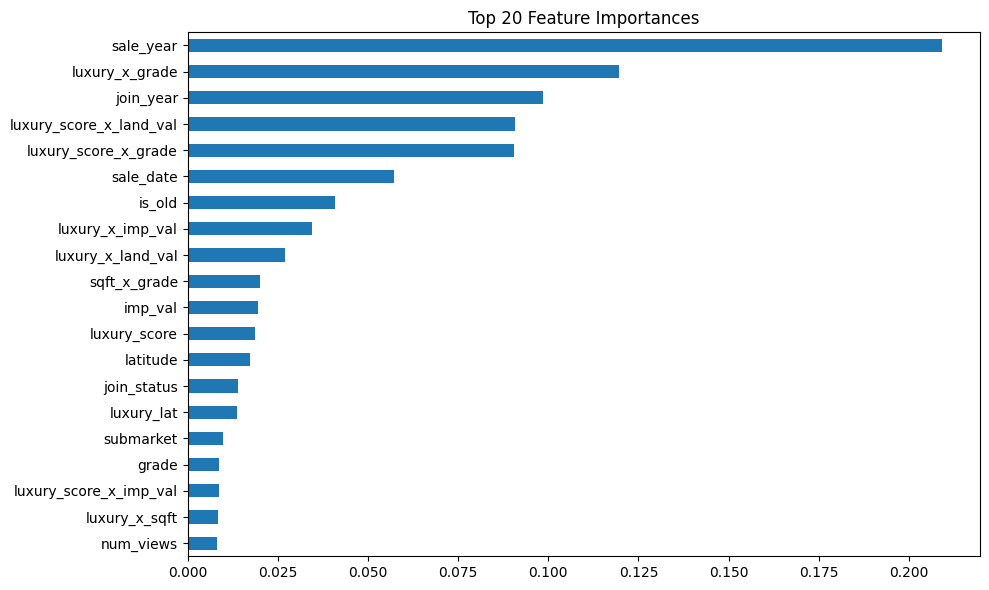

In [180]:
importance = pd.Series(best_xgb.feature_importances_, index=best_xgb.feature_names_in_)
top_feats = importance.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
top_feats.plot(kind='barh')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [185]:
# Reuse your original train/val/test split
best_full = XGBRegressor(**best_xgb.get_params())
best_full.fit(X_train, y_train)

y_val_pred_log = best_full.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)
y_val_true = np.expm1(y_val)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
r2 = r2_score(y_val_true, y_val_pred)

print(f"💪 Full Features RMSE: {rmse:,.2f}")
print(f"📈 Full Features R²: {r2:.4f}")


💪 Full Features RMSE: 96,918.80
📈 Full Features R²: 0.9391


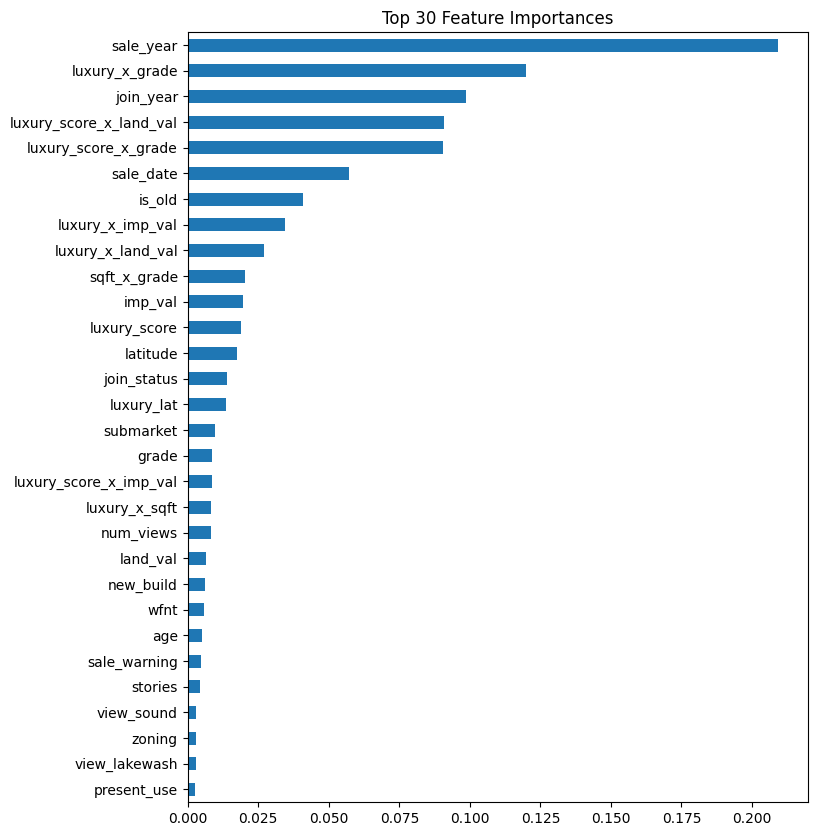

In [186]:
importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(30).plot(kind='barh', figsize=(8, 10))
plt.title("Top 30 Feature Importances")
plt.gca().invert_yaxis()
plt.show()